In [381]:
import matplotlib.pyplot as plt
import numpy as np

In [382]:
from enum import Enum
from typing import Literal

# General Scientific Constants
class universalConstants(float, Enum):
    charge = 1.602 * (1.0e-19)
    """
    single unit of charge of elctron / proton
    """

    h = 6.626 * (1.0e-34)
    """
    Plank's Constant 
    """

    c = 2.997 * (1.0e+8)
    """
    Speed of light in vacuum 
    """

#### Parameters required for numerical analysis
Macroscopic Laser model\
[laser dynamics and optical injection lock.pdf](laser%20dynamics%20and%20optical%20injection%20lock.pdf) Pg 31

In [383]:
# Specific Constants (all in SI units)

Tau_n = 0.74 * (1.0e-9)
""" Carrier lifetime (seconds) """

Tau_p = 0.74 * (1.0e-12)
""" Photon lifetime (seconds) """

g = 1.27 * (1.0e-12)
""" Differential gain coefficient (m^3 seconds^-1) """

Epsilon = 1.18 * (1.0e-23)    
""" Gain Compression factor (m^3) """

N_transparent = 0.85 * (1.0e+24)         
""" Carrier density at transparency (m^-3) """

Beta = 0.5 * (1.0e-5)         
""" Spontaneous enhancement factor """

Alpha = 2.7                 
""" Linewidth sample enhancement factor """

Eta = 0.2                   
""" Differential quantum efficiency """

Vol = 1.72 * (1.0e-17)          
""" Active layer volume (m^3) """

Gamma_cap = 0.27            
""" Mode confinement factor """

Kappa = 1.13 * (1.0e+11)      
""" OIL coupling term (Hz) """

Ng = 3.6
""" Group refractive index """

L = 250 * (1.0e-6)
""" Laser cavity length (m) """

Laser_lambda = 1550 * 1e-9
""" Laser wavelength (m) """

Laser_freq = universalConstants.c.value / Laser_lambda
""" free running frequency """

I_th = universalConstants.charge.value * Vol / Tau_n * (N_transparent  + 1 / (g * Gamma_cap * Tau_p))
""" Threshold Current for Lasing """

def phase_modulation_current(phase):
    """
    Delta Current needed for phase change\n
    phase: radians
    """
    val = 2.0 * Ng * universalConstants.charge.value * Vol / (Alpha * Laser_lambda * Eta * g * Tau_n * L)
    return val * phase

err_fault = 1e-9

### For controlling all different signals
To define specific signals

In [384]:
# Signal classes
class ArbitaryWave:
    """
    For Defining custom signals for current
    """
    def __init__(self, signal_name, t_unit, total_spread= 1.0):
        self.name = signal_name
        self.t_unit = t_unit
        self.signal_spread = 0.5 * total_spread 

    def __call__(self, t, args= None):
        return self.WaveSignal(t, args)
    
    def WaveSignal(self, t, args):
        """
        method override for actual wave
        """
        return 0

class LangevinNoise(ArbitaryWave):       
    """ 
    Langevin noise sources 
    """
    def __init__(self, signal_name, t_unit, total_spread= 1.0):
        super().__init__(signal_name, t_unit, total_spread)


class ArbitaryWaveGenerator:
    """
    Custom signal Generator
    """
    def __init__(self):
        self.signals = {}

    def reset_Signals(self):
        self.signals.clear()

    def write_Signals(self, signal_object: ArbitaryWave):
        self.signals[signal_object.name] = signal_object

    def get_Signals(self, singal_key, t, args= None):
        if(singal_key in self.signals):
            return self.signals[singal_key](t, args)
        return 0

#### Define the signals

In [385]:
# To control which bit modulates current
modulate_ON_bit = 0
modulate_OFF_bit = 1
modulation_bits = [1, 0, 1, 0, 1, 1, 1, 0, 0, 1]

# Control Constants (all in SI units)
dt = 1e-12
t_unit = 1e-9
t_cycles = len(modulation_bits)
sampling_rate = dt

print(f"Threshold Current = { I_th :2.4f} Amps")
MASTER_BASE_DC = 1.4 * I_th
MASTER_AC = 0 #phase_modulation_current(np.pi)

SLAVE_DC = 0.7 * I_th
SLAVE_PULSE = 1.15 * I_th
print(f"Master DC: {MASTER_BASE_DC :.4f} AC: {MASTER_AC :.4f}\nSlave DC: {SLAVE_DC :.4f}, Slave Pulse: {SLAVE_PULSE :.4f}")

Threshold Current = 0.0178 Amps
Master DC: 0.0250 AC: 0.0000
Slave DC: 0.0125, Slave Pulse: 0.0205


In [386]:
# Steady below lasing threshold current
class master_Base_signal(ArbitaryWave):
    def __init__(self, signal_name, t_unit, total_spread= 1.0):
        super().__init__(signal_name, t_unit, total_spread)

    def WaveSignal(self, t, args):
        return MASTER_BASE_DC

mBase = master_Base_signal("mBase", t_unit)

# Modulation current
class master_Modulation_signal(ArbitaryWave):
    def __init__(self, signal_name, t_unit, total_spread= 1.0):
        super().__init__(signal_name, t_unit, total_spread)
        self.sign = -1

    def WaveSignal(self, t, args):
        if(t == 0):
            self.sign *= -1
        elif(t > self.t_unit * (0.5 - self.signal_spread) and t < self.t_unit * (0.5 + self.signal_spread)):
            return MASTER_AC * self.sign
        return super().WaveSignal(t, args)

mModulation = master_Modulation_signal("mModulation", t_unit, 0.33)

# Pulse below lasing threshold current
class slave_Base_signal(ArbitaryWave):
    def __init__(self, signal_name, t_unit, total_spread= 1.0):
        super().__init__(signal_name, t_unit, total_spread)

    def WaveSignal(self, t, args):
        if(t > self.t_unit * (0.5 - self.signal_spread) and t < self.t_unit * (0.5 + self.signal_spread)):
            return SLAVE_DC
        return SLAVE_PULSE

sBase = slave_Base_signal("sBase", t_unit, 0.5)

AWG = ArbitaryWaveGenerator()
AWG.write_Signals(mBase)
AWG.write_Signals(mModulation)
AWG.write_Signals(sBase)

### Laser signal analysis
Using current driven model

In [387]:
class CurrentDriver:
    """ 
    Current Driver class
    """
    def __init__(self):
        self.modulation_bits = None
        self.idx = -1
        self.modulation_ON = []        
        self.modulation_OFF = []

    def set_Current(self, modulation_OFF: list[ArbitaryWave], modulation_ON: list[ArbitaryWave]= [], modulation_bits= None):
        """ 
        Current only controlled by modulations
        """
        self.idx = -1
        self.modulation_bits = modulation_bits

        for arbitarywaves in modulation_ON:
            self.modulation_ON.append(arbitarywaves.name)

        #print(self.modulation_ON)

        for arbitarywaves in modulation_OFF:
            self.modulation_OFF.append(arbitarywaves.name)

        #print(self.modulation_OFF)

    def set_Modulation(self, modulation_bits):
        """ 
        Set modulations bits
        """
        self.idx = -1
        self.modulation_bits = modulation_bits

    def I(self, t):                   
        """ 
        Driving current at t
        """
        I_t = 0

        if(self.modulation_bits is not None): 
            if(t == 0):
                self.idx += 1
                if(self.idx >= len(self.modulation_bits)): self.idx = 0

            # When modulating
            if(self.modulation_bits[self.idx] == modulate_ON_bit):
                for signal_name in self.modulation_ON:
                    I_t += AWG.get_Signals(signal_name, t)
                return I_t

        # When not modulating
        for signal_name in self.modulation_OFF:
            I_t += AWG.get_Signals(signal_name, t)
        return I_t

### Laser Rate equations
The dynamics of semiconductor laser is described by system of rate equations. In
general this system includes terms for carriers N, photon density S, and optical
phase ϕ: Pg 28

In [388]:
class Laser:
    """
    Laser class for simulations
    """

    def __init__(self, name, fr_freq=0, N0=N_transparent, S0=0.001, Phi0=0.001):
        self.name = name
        self.N0 = N0
        self.S0 = S0
        self.Phi0 = Phi0

        self.fr_freq = fr_freq
        """
        free running frequency
        """

        self.N_t = self.N0
        """
        Number of Carriers
        """

        self.S_t = self.S0
        """
        Photon density
        """

        self.Phi_t = self.Phi0
        """
        Optical phase
        """

        self.dPhi = 0
        """
        Stored instantaneous delta phase change
        """

        self.E_t = 0
        """
        Laser Optical field (complex)
        """
    
    def values(self):
        """
        Physical constraint check and get simulation values
        """
        self.N_t = max(err_fault, self.N_t)
        self.S_t = max(err_fault, self.S_t)

        # Phase goes from -pi to pi only
        Optical_phase = self.Phi_t #np.mod(self.Phi_t, 2 * np.pi) - np.pi
        self.E_t = np.sqrt(self.S_t) * np.exp2(1j * Optical_phase)

        return (self.N_t, self.S_t, self.Phi_t, self.E_t)

    def reset(self):
        """
        Reset all data
        """
        self.N_t = self.N0
        self.S_t = self.S0
        self.Phi_t = self.Phi0

        self.dPhi = 0
        self.E_t = 0

    def update(self, I_t, t, dt, Fn_t= 0.0, Fs_t= 0.0, Fphi_t= 0.0):
        """
        Update N, S, phi and return current value
        """
        temp_N_t = self.N_t + self.dN_dt(I_t, Fn_t) * dt 
        temp_S_t = self.S_t + self.dS_dt(Fs_t) * dt
        self.dPhi = self.dPhi_dt(Fphi_t) * dt

        """ time step update """ 
        self.N_t = temp_N_t
        self.S_t = temp_S_t
        self.Phi_t += self.dPhi

        return self.values()

    def dN_dt(self, I_t, Fn_t):
        """
        delta Number of Carriers
        """
        val = I_t / (universalConstants.charge.value * Vol) - self.N_t / Tau_n - g * ((self.N_t - self.N0) / (1.0 + Epsilon * self.S_t)) * self.S_t + Fn_t
        return val

    def dS_dt(self, Fs_t):
        """
        delta Photon density
        """
        val = Gamma_cap * g * ((self.N_t - self.N0) / (1.0 + Epsilon * self.S_t)) * self.S_t - self.S_t / Tau_p + Gamma_cap * Beta * self.N_t / Tau_n + Fs_t
        return val

    def dPhi_dt(self, Fphi_t):
        """
        delta Optical phase
        """
        val = (Alpha / 2.0) * (Gamma_cap * g * (self.N_t - self.N0) - 1.0 / Tau_p) + Fphi_t
        return val
    
def Power(S_t, fr_freq):
    """ 
    Power of laser 
    """
    Pval = np.array(S_t) * Vol * Eta * universalConstants.h.value * fr_freq / (2.0 * Gamma_cap * Tau_p)
    return Pval
    
master_laser = Laser("Master", Laser_freq)
master_current = CurrentDriver()

In [389]:
class LaserSimulator:
    """
    Simulator Class for lasers
    """
    def __init__(self):
        self.data = {
            "current": {},
            "carriers": {},
            "photons": {},
            "absolute_phases": {},
            "optical_fields": {},
            "time": {}
        }

        self.t_cycles = 0
        self.t_unit = None
        self.dt = None
        self.t = 0
        self.sampling_rate = None

    def reset(self):
        """
        Clear all data and set time to 0
        """
        for key in self.data:
            self.data[key].clear()
        self.reset_time()

    def reset_time(self):
        """
        Only set time to 0
        """
        self.t = 0

    def set_Parameters(self, t_unit, dt, t_cycles, sampling_rate):
        self.t_unit = t_unit
        self.dt = dt
        self.t_cycles = t_cycles
        self.sampling_rate = sampling_rate

    def lasers_simulate(self, laser_models: list[Laser], current_drivers: list[CurrentDriver]):
        for idx, laser in enumerate(laser_models):
            for key in self.data:
                if(laser.name in self.data[key]): break
                self.data[key][laser.name] = []

        for _ in range(self.t_cycles):
            t = 0
            t_sample = 0.0

            while(t < self.t_unit):
                for idx, laser in enumerate(laser_models):

                    # corresponding laser and current driver
                    I_t = current_drivers[idx].I(t)
                    
                    (c, p, ph, ef)= laser.update(I_t, self.t, self.dt)

                    if(t_sample >= self.sampling_rate):
                        self.data["current"][laser.name].append(I_t)
                        self.data["carriers"][laser.name].append(c)
                        self.data["photons"][laser.name].append(p)
                        self.data["absolute_phases"][laser.name].append(ph)
                        self.data["optical_fields"][laser.name].append(ef)

                        self.data["time"][laser.name].append(self.t)

                if(t_sample >= self.sampling_rate): t_sample = 0
                else: t_sample += self.dt

                t += self.dt
                self.t += self.dt
            
        print(f"No. of samples {len(self.data["time"][(laser_models[0]).name])}")

    def plot_power(self, laser_models: list[Laser]):
        """ 
        Returns power output of Laser
        """
        plt.figure(figsize=(12, 6)) # Create a figure for the plot
        for laser in laser_models:
            power_val = Power(self.data["photons"][laser.name], laser.fr_freq)
            plt.plot(self.data["time"][laser.name], power_val, label= laser.name)

        plt.ylabel("Power (Watt)")
        plt.grid()
        plt.legend()
        plt.show()

    def plot_data(self, laser_models: list[Laser]):
        """
        Plot the simulation data
        """

        plt.figure(figsize=(12, 6)) # Create a figure for the plot
        p = 1
        for key in self.data:
            if(key != "time"):
                plt.subplot(2,2,p)
                
                for laser in laser_models:
                    plt.plot(self.data["time"][laser.name], self.data[key][laser.name], label= laser.name)

                plt.xlabel(f"time")
                plt.ylabel(key)
                plt.grid()
                p += 1
            if(p > 4): break

        plt.legend()
        plt.show()

    def plot_Optical_data(self, laser_models: list[Laser], mode: Literal["cartesian", "hybrid", "polar"] = "cartesian"):
        """
        Plot the simulation data for Optical output
        """
        plt.figure(figsize=(12, 6)) # Create a figure for the plot


        # Real plot
        plt.subplot(1,2,1)
        for laser in laser_models:
            plot_data = np.array(self.data['optical_fields'][laser.name])

            if(mode == "cartesian" or mode == "hybrid"):
                plot_data = plot_data.real
                plt.ylabel("Real part of field")
            else:
                plot_data = np.abs(plot_data)
                plt.ylabel("Magnitude of field")
            plt.plot(self.data["time"][laser.name], plot_data, label= laser.name)
        
        plt.xlabel("time")
        plt.grid()

        # Complex plot
        plt.subplot(1,2,2)
        for laser in laser_models:
            plot_data = np.array(self.data['optical_fields'][laser.name])

            if(mode == "cartesian"):
                plot_data = plot_data.imag
                plt.ylabel("Complex part of field")
            else:
                plot_data = np.angle(plot_data)
                plt.ylabel("Phase of field")
            plt.plot(self.data["time"][laser.name], plot_data, label= laser.name)
        
        plt.xlabel("time")
        plt.grid()

        plt.legend()
        plt.show()

    def values(self):
        """
        Returns simulation data for all lasers
        """
        return self.data

### Master Laser (Phase Prep Laser)

In [390]:
master_current.set_Current([mBase], [mBase, mModulation], modulation_bits)

laser_simulator = LaserSimulator()
laser_simulator.set_Parameters(t_unit, dt, t_cycles, sampling_rate)
laser_simulator.lasers_simulate([master_laser], [master_current])

No. of samples 5000


#### plots for  current driven model analysis

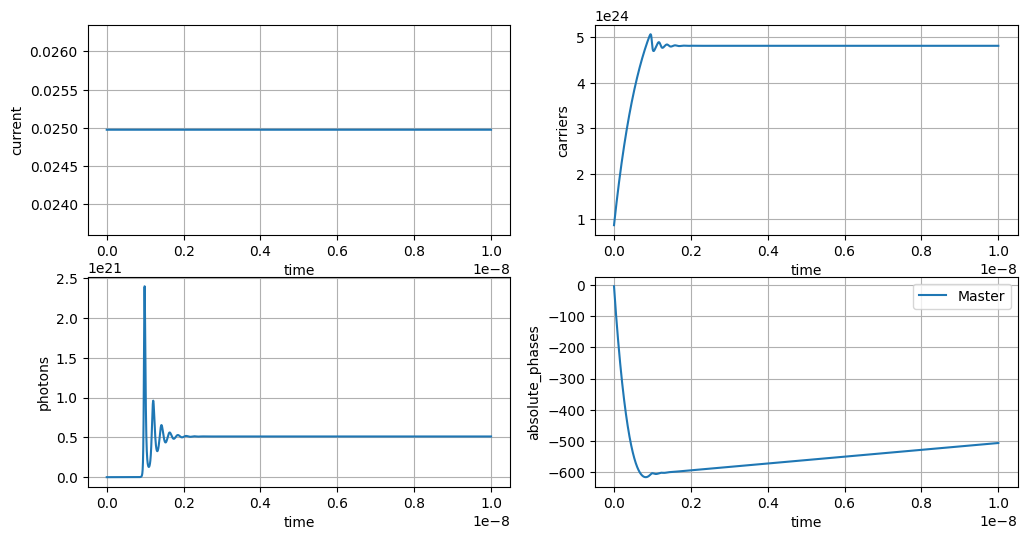

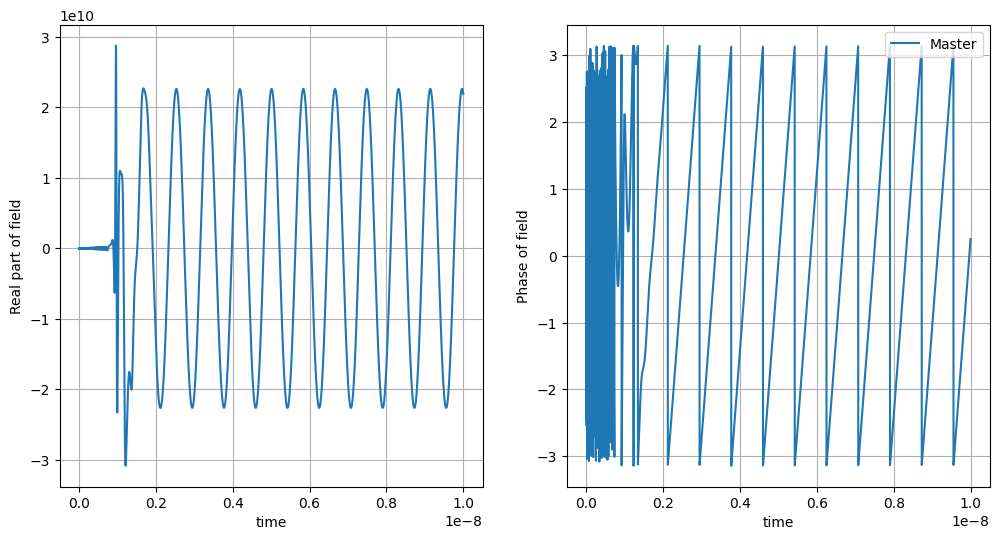

In [391]:
laser_simulator.plot_data([master_laser])
laser_simulator.plot_Optical_data([master_laser], mode= "hybrid")

### Slave Laser (Pulse Prep Laser)

In [392]:
class SlaveLaser(Laser):
    """
    Slave Laser class\n
    Parent: Laser class
    """
    def __init__(self, name, fr_freq=0, N0=N_transparent, S0=0.001, Phi0=0.001):
        super().__init__(name, fr_freq, N0, S0, Phi0)
        
        self.master_laser = None
        """ injection Master laser """

    def set_master_laser(self, master_laser: Laser):
        """
        Set stabilised master laser
        """
        self.master_laser = master_laser
        
        self.Delta_Winj = self.fr_freq - master_laser.fr_freq
        """ frequency detuning """

    def update(self, I_t, t, dt= 1e-3, Fn_t= 0.0, Fs_t= 0.0, Fphi_t= 0.0):
        """
        Update N, S, phi for slave laser and return current value
        """
        # Optical Injection Lock Terms
        if(self.master_laser is not None):
            Delta_phi = self.Phi_t - self.master_laser.Phi_t - self.Delta_Winj * t

            temp_N_t = self.N_t + self.dN_dt(I_t, Fn_t) * dt 
            temp_S_t = self.S_t + (self.dS_dt(Fs_t) + 2 * Kappa * np.sqrt(self.master_laser.S_t * self.S_t) * np.cos(Delta_phi)) * dt
            self.dPhi = (self.dPhi_dt(Fphi_t) - Kappa * np.sqrt(self.master_laser.S_t / self.S_t) * np.sin(Delta_phi)) * dt
        
            """ time step update """ 
            self.N_t = temp_N_t
            self.S_t = temp_S_t
            self.Phi_t += self.dPhi
        else:
            return super().update(I_t, t, dt, Fn_t, Fs_t, Fphi_t)
        return self.values()
    
slave_laser = SlaveLaser("Slave", Laser_freq)
slave_current = CurrentDriver()
slave_current.set_Current(modulation_OFF= [sBase])

No. of samples 5000


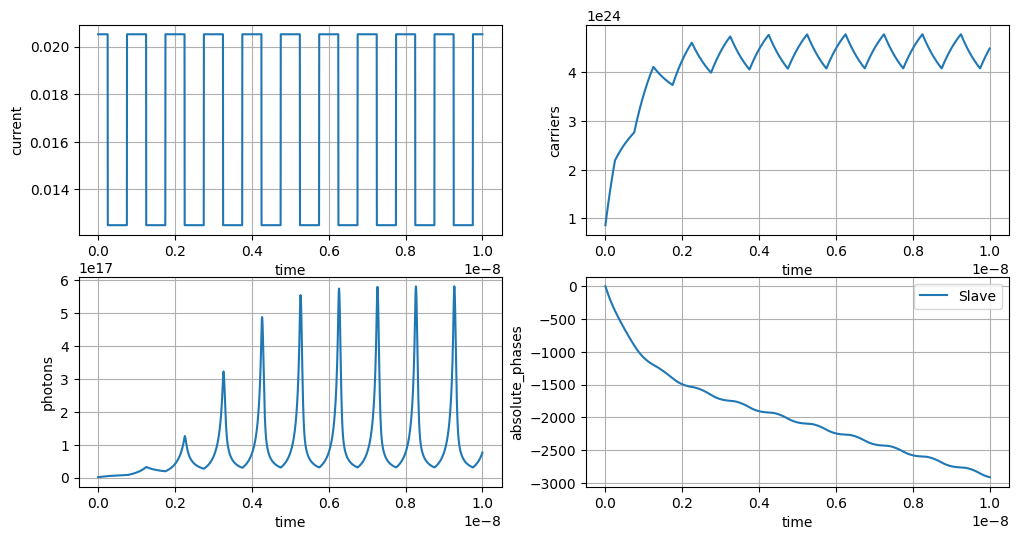

In [393]:
laser_simulator.reset_time()
laser_simulator.lasers_simulate([slave_laser], [slave_current])

laser_simulator.plot_data([slave_laser])

### Optical Injection locking
Using a master laser to lock a slave laser

No. of samples 10000


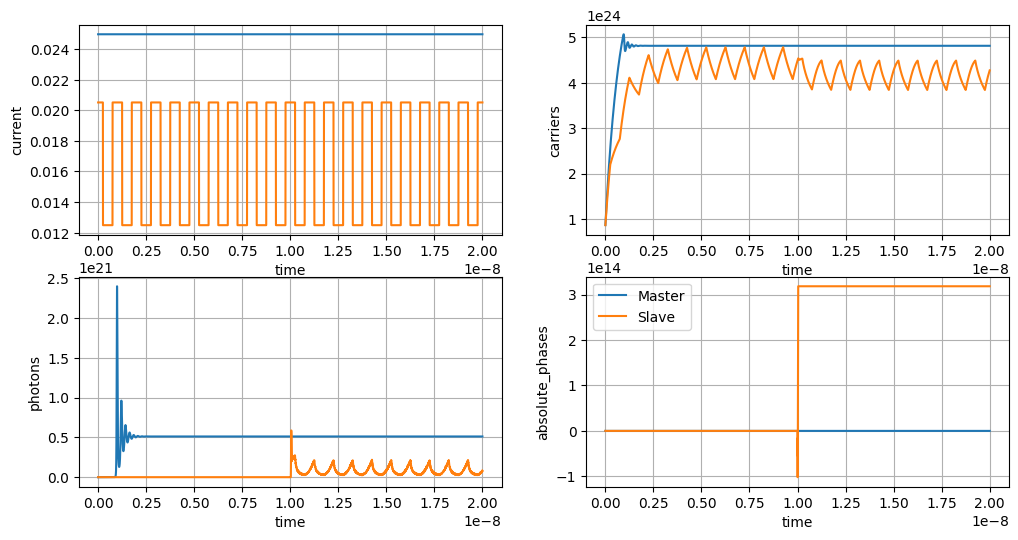

In [394]:
# OIL setup
slave_laser.set_master_laser(master_laser)

# Allow initial locking
laser_simulator.lasers_simulate([master_laser, slave_laser], [master_current, slave_current])
laser_simulator.plot_data([master_laser, slave_laser])

# not Allow initial locking
# master_laser.reset()
# slave_laser.reset()

No. of samples 5000


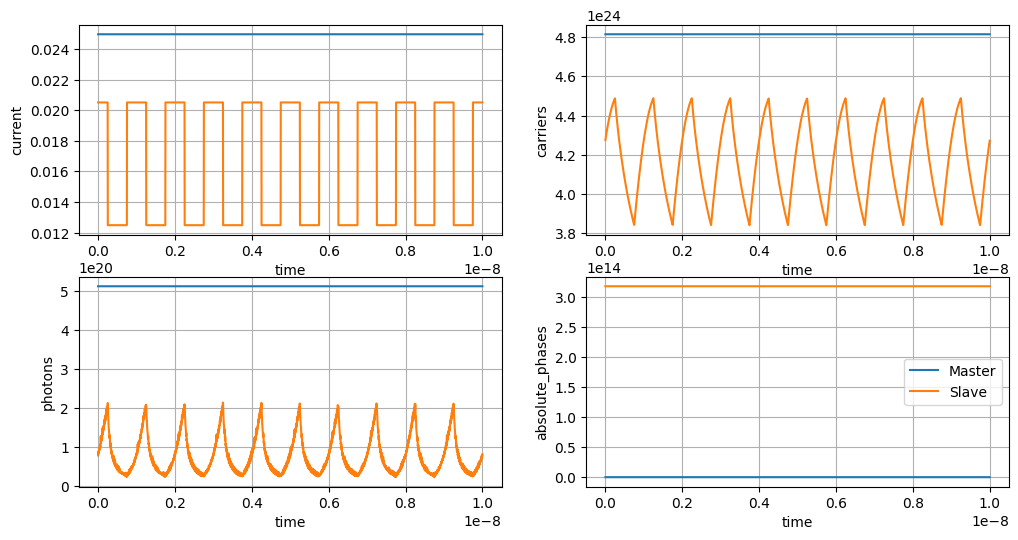

In [395]:
laser_simulator.reset()

# OIL state
master_current.set_Modulation(modulation_bits)

laser_simulator.set_Parameters(t_unit, dt, t_cycles, sampling_rate)
laser_simulator.lasers_simulate([master_laser, slave_laser], [master_current, slave_current])

# laser simulator outputs
simulation_data = laser_simulator.values()
""" simulation data (shallow copy of laser_simulator.data) """

laser_simulator.plot_data([master_laser, slave_laser])

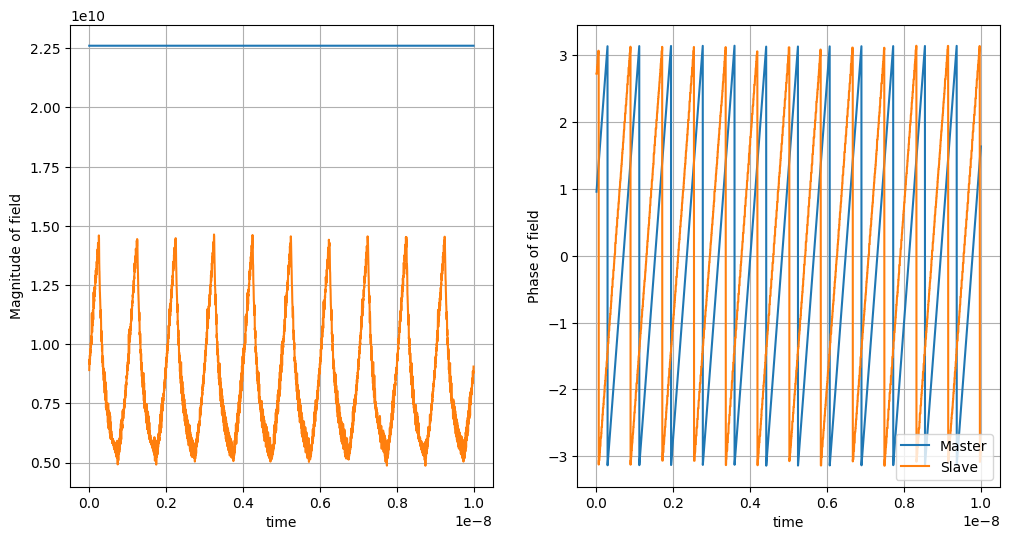

In [396]:
# For Electric field output
laser_simulator.plot_Optical_data([master_laser, slave_laser], mode= "polar")

### Power comparision

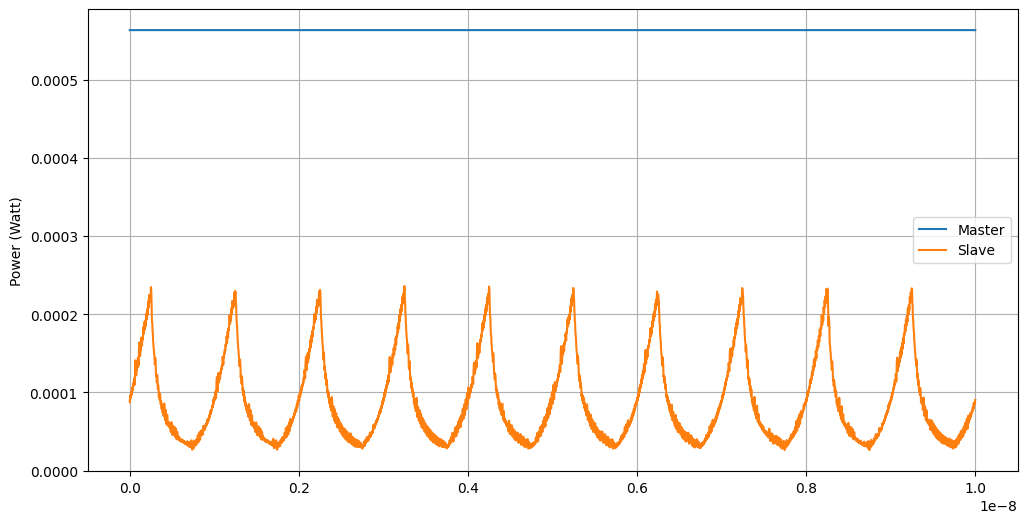

In [397]:
laser_simulator.plot_power([master_laser, slave_laser])

### PhaseSample, SinglePhotonDetectors, AMZI

In [398]:
class PhaseSample:
    """
    PhaseSample Class
    """
    def __init__(self, phase_delay= 0):
        self.phi = np.exp(1j * phase_delay)
        """ Phase delay """

    def set_value(self, phase_delay):
        self.phi = np.exp(1j * phase_delay)

    def __call__(self, E):
        return self.phi * E

class SinglePhotonDetector:
    """
    Single Photon Detector class
    """
    def __init__(self):
        self.interference_data = []

    def __call__(self, signal):
        self.interference_data.append(signal)

    def reset(self):
        self.interference_data.clear()

    def values(self):
        return np.array(self.interference_data)

class AMZI:
    """
    Asymetric Mach-Zehnder Interferometer Class
    """
    def __init__(self, t_delay):
        self.t_delay = t_delay
        """ time delay of pulse"""

        self.time = None

        # Arm phase change
        self.phase_sample_long = PhaseSample()
        self.phase_sample_short = PhaseSample()

        self.SPD_1 = SinglePhotonDetector()
        self.SPD_2 = SinglePhotonDetector()

    def adjust_arm_phases(self, long_arm_phase= 0, short_arm_phase= 0):
        """ Adjust component values """

        self.phase_sample_long.set_value(long_arm_phase)
        self.phase_sample_short.set_value(short_arm_phase)

    def interference(self, E_t1, E_t2):
        """
        Simulate inteference
        """

        E1 = 0.5 * self.phase_sample_long(E_t1)
        E2 = 0.5 * self.phase_sample_short(E_t2)
        return (E1 + E2, E1 - E2)

    def reset(self):
        self.SPD_1.reset()
        self.SPD_2.reset()

    def simulate_DPS(self, signal, time):
        """
        Simulate inteference with time delay and Differential Phase Shift
        """

        delt_idx = 0
        t_idx = 0

        # Convert time delay to index difference
        while(time[delt_idx] < self.t_delay): 
            delt_idx += 1

        self.time = np.array(time[:-delt_idx])

        num_values = len(time)
        while(t_idx + delt_idx < num_values):
            interference_data = self.interference(signal[t_idx], signal[t_idx + delt_idx])
            
            # Send interfered signal to detectors
            self.SPD_1(interference_data[0])
            self.SPD_2(interference_data[1])

            t_idx += 1

    def plot_SPD_data(self):
        """
        Plot the simulation data from Detectors
        """
        plt.figure(figsize=(12, 6)) # Create a figure for the plot
        plt.ylabel("Intensity")
        plt.xlabel("time")

        # Magnitude plot
        plt.plot(self.time, np.abs(self.SPD_1.values()), label= "D1")
        plt.plot(self.time, np.abs(self.SPD_2.values()), label= "D2")

        plt.grid()
        plt.legend()
        plt.show()

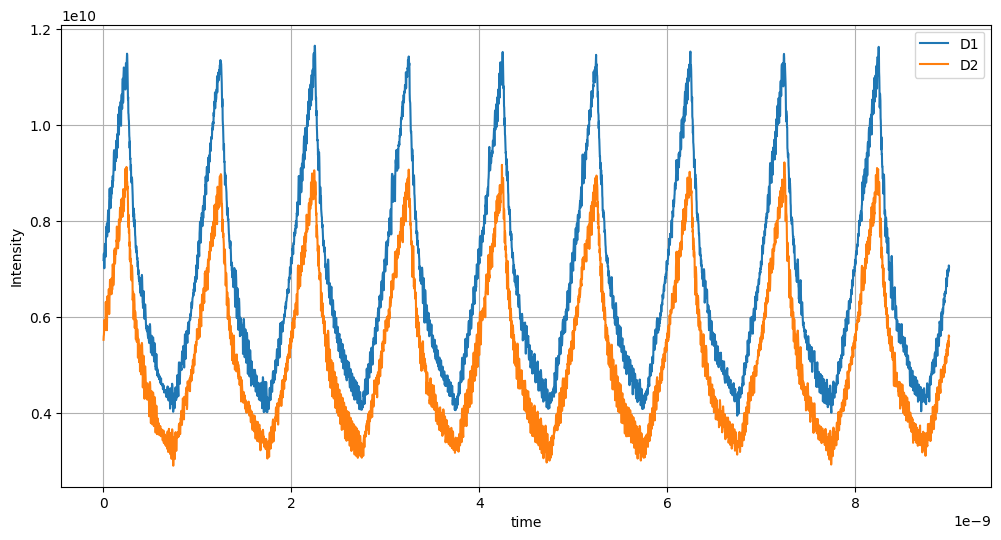

In [399]:
AMZI_interferometer = AMZI(t_unit)
AMZI_interferometer.simulate_DPS(simulation_data['optical_fields'][slave_laser.name],
                                 simulation_data['time'][slave_laser.name])
AMZI_interferometer.plot_SPD_data()

In [400]:
#Interferometer.simulate_interference()
#Interferometer.plot_interference_data()